In [14]:
# Imports
#---------
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator, DayLocator
import matplotlib as mpl
import warnings
import seaborn as sns
from scipy import stats
import copy
from scipy.stats import wilcoxon
import seaborn as sns
from matplotlib.patches import Rectangle

warnings.filterwarnings("ignore")

register_matplotlib_converters()

# File locations
#----------------
#the_gases = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/'
pngs = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/pngs/'
data_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/jun_to_sept_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'
aurn_path = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/aurn_2016_2021/'


cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_under("white")

def color_nan_white(val):
#     """Color the nan text white"""
    if np.isnan(val):
        return 'color: white'

def color_nan_white_background(val):
#      """Color the nan cell background white"""
    if np.isnan(val):
        return 'background-color: white'
    
def color_nonnan_black(val):
#     """Color the non-nan text white"""
    if pd.notna(val):
        return 'color: black'
    
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [15]:
# Load senssor data at 24hr resolution
#--------------------------------------
sensors_24hr = pd.read_feather(stats_home+'sensors_24hr_9095.ftr').drop('index', axis=1)
sensors_24hr['fname'] = sensors_24hr['fname'].replace(regex={'Jahlul':'Ahlul', 'Mosque':'Centre','Marsten':'Marston'}) 


# Load sebbes typical values 2016-21 for graphing
#-------------------------------------------------
sebbes_pm10_ld_event_desc_mean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10_1619_9095.ftr')
sebbes_pm25_ld_event_desc_mean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25_1619_9095.ftr')

# Load sebbes data with ordinal day & LD event codes
#-----------------------------------------------------
sebbes_ordinal_daymean_codeup_ak = pd.read_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_1619_9095.ftr')

In [16]:
# Fill gaps in data with NaNs for easy plotting - pm10
#------------------------------------------------------

sensor_ld_event_stats = sensors_24hr.groupby(['fname','ld_code']).mean().sort_values(['fname','ld_code'])
sensors = pd.DataFrame(sorted(list(sensor_ld_event_stats.index.get_level_values(0).unique())), columns=['sensor'])
events = pd.DataFrame(sorted(['a','b','c','d','e','f','g','h','i','j','k']))

tmplist = []
for i, j in sensors.iterrows():
    for ii, jj in events.iterrows():
        tmp = pd.DataFrame(zip(j,jj), columns=['sensors','events'])
        tmplist.append(tmp)
sevents = pd.concat(tmplist).reset_index(drop=True)

sensor_ld_event_stats_1 = sevents.merge(sensor_ld_event_stats.reset_index(), left_on=['sensors','events'], right_on=['fname','ld_code'], how='left')
sensor_ld_event_stats_1['ld_code'] = sensor_ld_event_stats_1['events']
sensor_ld_event_stats_1['fname'] = sensor_ld_event_stats_1['sensors']
sensor_ld_event_stats_1.drop(['sensors','events'], inplace=True, axis=1)
sensor_ld_event_stats_1.set_index('ld_code', inplace=True)

sensors_24hr['fname'].unique()

array(['Ahlul Bayt Centre', 'County Hall', 'Divinity Rd', 'High St',
       'Jesus College', 'John Radcliffe', 'New Marston',
       'Said Business School', 'South Parks Rd', 'Speedwell St',
       'St Ebbes', 'St Giles', 'The Plain', 'Warneford Hospital',
       'Worcester College'], dtype=object)

In [17]:
sensors_24hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   fname         6107 non-null   object             
 1   rec           6107 non-null   datetime64[ns, UTC]
 2   pm10_count    6107 non-null   float64            
 3   pm10_mean     6016 non-null   float64            
 4   pm10_std      6011 non-null   float64            
 5   pm10_min      6016 non-null   float64            
 6   pm10_p50      6016 non-null   float64            
 7   pm10_p90      6016 non-null   float64            
 8   pm10_p95      6016 non-null   float64            
 9   pm10_max      6016 non-null   float64            
 10  pm25_count    6107 non-null   float64            
 11  pm25_mean     6031 non-null   float64            
 12  pm25_std      6012 non-null   float64            
 13  pm25_min      6031 non-null   float64            
 14  pm25_p50

In [18]:
sebbes_ordinal_daymean_codeup_ak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       658 non-null    int64  
 1   date        658 non-null    int64  
 2   pm25_count  658 non-null    float64
 3   pm25_mean   655 non-null    float64
 4   pm25_std    655 non-null    float64
 5   pm25_min    655 non-null    float64
 6   pm25_50%    655 non-null    float64
 7   pm25_90%    655 non-null    float64
 8   pm25_95%    655 non-null    float64
 9   pm25_max    655 non-null    float64
 10  pm10_count  658 non-null    float64
 11  pm10_mean   657 non-null    float64
 12  pm10_std    657 non-null    float64
 13  pm10_min    657 non-null    float64
 14  pm10_50%    657 non-null    float64
 15  pm10_90%    657 non-null    float64
 16  pm10_95%    657 non-null    float64
 17  pm10_max    657 non-null    float64
 18  y10         657 non-null    float64
 19  ypm1095     657 non-null    f

In [19]:
# Create matched-paired data sensor-sebbes data for each sensor by fname & lockdown event, merging data on ordinal day
#----------------------------------------------------------------------------------------------------------------------
tmplist = []
for i, g in sensors_24hr.iloc[:,[0,1,3,7,8,11,15,16,19,20]].groupby(['fname','ld_code']):
    gg = g.merge(sebbes_ordinal_daymean_codeup_ak[['pm10_mean','pm10_90%','pm10_95%','pm25_mean','pm25_90%','pm25_95%','ld_code','date']].query('ld_code == @i[1]'), 
                 left_on='ordinal_days', 
                 right_on='date',
                 how='outer',
                 suffixes=(None,'_s')).rename(columns={'pm10_95%':'pm10_p95_s','pm10_90%':'pm10_p90_s','pm25_95%':'pm25_p95_s','pm25_90%':'pm25_p90_s'})
    tmplist.append(gg)
sensor_sebbes = pd.concat(tmplist).dropna(axis=0, subset=['rec','pm10_mean'])
#sensor_sebbes.reset_index().to_feather(stats_home+'sensor_sebbes_24hr.ftr')
sensor_sebbes


,fname,rec,pm10_mean,pm10_p90,pm10_p95,pm25_mean,pm25_p90,pm25_p95,ordinal_days,ld_code,pm10_mean_s,pm10_p90_s,pm10_p95_s,pm25_mean_s,pm25_p90_s,pm25_p95_s,ld_code_s,date
0,Ahlul Bayt Centre,2020-08-24 00:00:00+00:00,7.952646,7.587656,14.328107,2.199089,3.730718,3.873972,237.0,c,11.647569,20.7675,22.55750,8.138514,14.1782,14.63805,c,237
1,Ahlul Bayt Centre,2020-08-25 00:00:00+00:00,7.354597,10.209729,10.351464,3.630088,7.065414,7.899002,238.0,c,13.447917,20.8325,21.40625,9.638264,14.0259,14.91395,c,238
2,Ahlul Bayt Centre,2020-08-26 00:00:00+00:00,7.708317,11.898879,12.090949,4.809805,7.409988,7.514912,239.0,c,10.722569,20.9875,25.14250,7.400444,13.8754,15.63840,c,239
3,Ahlul Bayt Centre,2020-08-27 00:00:00+00:00,12.283199,15.901752,16.930179,8.332971,13.153130,13.685830,240.0,c,10.578125,19.0000,21.59500,7.791583,14.4800,17.87000,c,240
4,Ahlul Bayt Centre,2020-08-28 00:00:00+00:00,7.572427,10.211047,11.399162,3.732493,5.669046,9.127783,241.0,c,8.822222,14.0000,14.34500,6.604736,11.6500,13.60000,c,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Worcester College,2021-09-26 00:00:00+00:00,12.629374,22.397860,26.826290,10.416576,21.534583,22.928924,269.0,k,18.635417,37.2000,43.32500,15.073153,34.3300,37.85500,k,269
98,Worcester College,2021-09-27 00:00:00+00:00,5.782544,7.893207,8.191074,3.562348,4.693492,5.027340,270.0,k,19.680903,44.9300,50.21500,14.914194,35.2800,43.78500,k,270
99,Worcester College,2021-09-28 00:00:00+00:00,8.334442,10.693214,11.254139,5.419416,6.416595,7.009682,271.0,k,7.906250,11.9700,12.49000,4.218806,8.2700,8.62500,k,271
100,Worcester College,2021-09-29 00:00:00+00:00,5.580304,8.652796,9.470717,2.901159,4.341330,4.587047,272.0,k,8.886806,15.0000,21.33500,5.504917,10.8900,15.19000,k,272


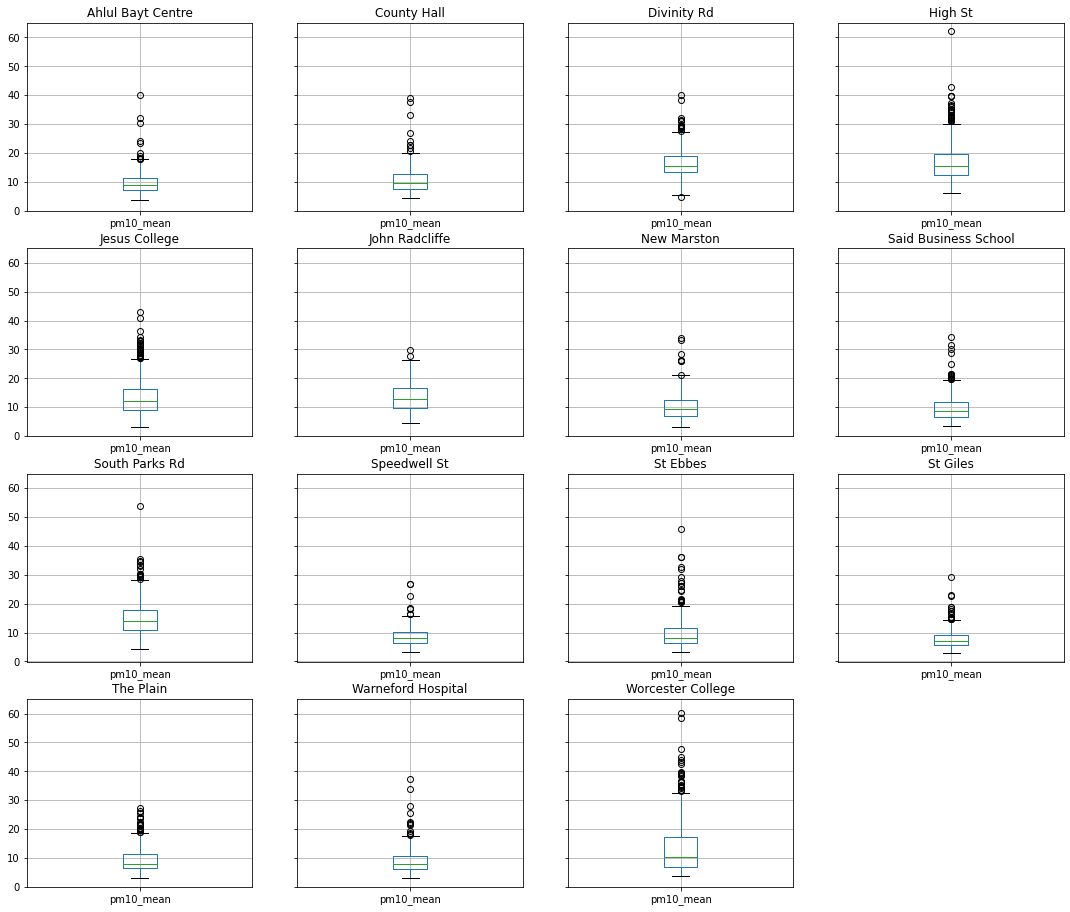

In [20]:
sensor_sebbes.groupby('fname').boxplot(column=['pm10_mean'], figsize=(18,16))
plt.show()

In [21]:
sensor_ld_event_stats_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, a to k
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fname         165 non-null    object 
 1   pm10_count    131 non-null    float64
 2   pm10_mean     131 non-null    float64
 3   pm10_std      131 non-null    float64
 4   pm10_min      131 non-null    float64
 5   pm10_p50      131 non-null    float64
 6   pm10_p90      131 non-null    float64
 7   pm10_p95      131 non-null    float64
 8   pm10_max      131 non-null    float64
 9   pm25_count    131 non-null    float64
 10  pm25_mean     131 non-null    float64
 11  pm25_std      131 non-null    float64
 12  pm25_min      131 non-null    float64
 13  pm25_p50      131 non-null    float64
 14  pm25_p90      131 non-null    float64
 15  pm25_p95      131 non-null    float64
 16  pm25_max      131 non-null    float64
 17  ordinal_hrs   131 non-null    float64
 18  ordinal_days  131 non-null    float64

In [22]:
# Creat a table of differentials - pm10 mean
#---------------------------------------------
# df = sensor_ld_event_stats_1.iloc[:,[0,1,2,3,4,5,6,7,8]].reset_index().merge(sebbes_pm10_ld_event_desc_mean[['ld_code','pm10_mean','pm10_95%']], 
#                                                              left_on='ld_code',
#                                                              right_on='ld_code',
#                                                              how='left',
#                                                              suffixes=(None,'_s')
#                                                             ).rename(columns={'pm10_95%':'pm10_p95_s'})

df = sensor_ld_event_stats_1.reset_index().merge(sebbes_pm10_ld_event_desc_mean[['ld_code','pm10_mean','pm10_90%','pm10_95%']], 
                                                             left_on='ld_code',
                                                             right_on='ld_code',
                                                             how='left',
                                                             suffixes=(None,'_s')
                                                            ).rename(columns={'pm10_95%':'pm10_p95_s','pm10_90%':'pm10_p90_s'})

df['dif_pm10_mean'] = df['pm10_mean'] - df['pm10_mean_s']
df['dif_pm10_95'] = df['pm10_p95'] - df['pm10_p95_s']
df['dif_pm10_90'] = df['pm10_p90'] - df['pm10_p90_s']

df = df.rename(columns={'ld_code': 'Event code', 'fname': 'Sensor'})
dif_pm10_mean = df[['Event code','Sensor','dif_pm10_mean']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm10_mean.loc['Mean',:] = dif_pm10_mean.mean(axis=0)
dif_pm10_mean.loc[:,'Mean'] = dif_pm10_mean.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_mean'].values, g['pm10_mean_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm10_mean_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

dif_pm10_p95 = df[['Event code','Sensor','dif_pm10_95']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm10_p95.loc['Mean',:] = dif_pm10_p95.mean(axis=0)
dif_pm10_p95.loc[:,'Mean'] = dif_pm10_p95.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_p95'].values, g['pm10_p95_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm10_p95_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

dif_pm10_p90 = df[['Event code','Sensor','dif_pm10_90']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm10_p90.loc['Mean',:] = dif_pm10_p90.mean(axis=0)
dif_pm10_p90.loc[:,'Mean'] = dif_pm10_p90.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(g['pm10_p90'].values, g['pm10_p90_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm10_p90_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

pm10_mean_wilcoxon_a = pm10_mean_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
pm10_mean_wilcoxon_a.loc['Mean',:] = pm10_mean_wilcoxon_a.mean(axis=0)
pm10_mean_wilcoxon_a.loc[:,'Mean'] = pm10_mean_wilcoxon_a.mean(axis=1)

pm10_p95_wilcoxon_a = pm10_p95_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
pm10_p95_wilcoxon_a.loc['Mean',:] = pm10_p95_wilcoxon_a.mean(axis=0)
pm10_p95_wilcoxon_a.loc[:,'Mean'] = pm10_p95_wilcoxon_a.mean(axis=1)

pm10_p90_wilcoxon_a = pm10_p90_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
pm10_p90_wilcoxon_a.loc['Mean',:] = pm10_p90_wilcoxon_a.mean(axis=0)
pm10_p90_wilcoxon_a.loc[:,'Mean'] = pm10_p90_wilcoxon_a.mean(axis=1)

display(dif_pm10_mean.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    pm10_mean_wilcoxon_a < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    pm10_mean_wilcoxon_a < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}"),
        dif_pm10_p95.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    pm10_p95_wilcoxon_a < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    pm10_p95_wilcoxon_a < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}"),
        dif_pm10_p95.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    pm10_p95_wilcoxon_a < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    pm10_p95_wilcoxon_a < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}")
        
       
       )


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
Ahlul Bayt Centre,nan,nan,0.1,-3.2,-0.1,-1.7,-5.2,-6.6,-5.0,-3.9,-1.3,-3.0
County Hall,nan,nan,nan,nan,nan,-1.8,-4.3,-5.9,-4.0,-2.8,0.5,-3.1
Divinity Rd,nan,nan,6.4,3.1,5.7,3.7,0.9,2.5,2.1,2.7,4.1,3.5
High St,nan,nan,nan,6.2,8.4,3.9,1.4,5.6,4.3,1.5,4.0,4.4
Jesus College,-0.8,0.1,-1.0,-0.9,3.9,3.8,1.2,0.5,3.8,-1.5,-0.4,0.8
John Radcliffe,nan,nan,nan,nan,nan,2.3,-2.1,-0.7,-0.0,0.8,1.5,0.3
New Marston,nan,nan,0.8,-1.4,4.1,-0.5,-6.2,-7.5,-6.3,-4.8,nan,-2.7
Said Business School,nan,nan,-0.1,-3.3,0.5,-1.7,-5.1,-3.9,-4.7,-2.8,-1.2,-2.5
South Parks Rd,nan,nan,4.1,-1.1,1.7,2.4,-1.1,-0.1,1.1,4.1,6.5,2.0


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
Ahlul Bayt Centre,nan,nan,-3.1,-12.0,-1.7,-7.4,-16.9,-20.3,-16.9,-8.2,-4.7,-10.1
County Hall,nan,nan,nan,nan,nan,-7.6,-15.4,-18.2,-15.4,-7.1,-1.8,-10.9
Divinity Rd,nan,nan,6.7,-3.1,5.9,-0.8,-9.2,-7.7,-6.5,-0.5,4.9,-1.1
High St,nan,nan,nan,3.7,10.5,0.1,-6.8,-2.0,0.3,-1.9,3.4,0.9
Jesus College,-10.3,-9.1,-4.2,-8.5,2.8,-1.2,-8.3,-10.5,-0.5,-6.7,-3.2,-5.4
John Radcliffe,nan,nan,nan,nan,nan,0.1,-11.2,-10.1,-7.5,-0.3,-0.5,-4.9
New Marston,nan,nan,-2.2,-9.3,1.2,-5.0,-18.4,-21.5,-18.5,-10.1,nan,-10.5
Said Business School,nan,nan,-3.2,-11.4,-1.2,-6.4,-16.2,-16.6,-15.4,-6.6,-4.3,-9.0
South Parks Rd,nan,nan,3.5,-7.9,-1.0,-1.3,-10.9,-11.2,-7.7,3.5,7.8,-2.8


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
Ahlul Bayt Centre,nan,nan,-3.1,-12.0,-1.7,-7.4,-16.9,-20.3,-16.9,-8.2,-4.7,-10.1
County Hall,nan,nan,nan,nan,nan,-7.6,-15.4,-18.2,-15.4,-7.1,-1.8,-10.9
Divinity Rd,nan,nan,6.7,-3.1,5.9,-0.8,-9.2,-7.7,-6.5,-0.5,4.9,-1.1
High St,nan,nan,nan,3.7,10.5,0.1,-6.8,-2.0,0.3,-1.9,3.4,0.9
Jesus College,-10.3,-9.1,-4.2,-8.5,2.8,-1.2,-8.3,-10.5,-0.5,-6.7,-3.2,-5.4
John Radcliffe,nan,nan,nan,nan,nan,0.1,-11.2,-10.1,-7.5,-0.3,-0.5,-4.9
New Marston,nan,nan,-2.2,-9.3,1.2,-5.0,-18.4,-21.5,-18.5,-10.1,nan,-10.5
Said Business School,nan,nan,-3.2,-11.4,-1.2,-6.4,-16.2,-16.6,-15.4,-6.6,-4.3,-9.0
South Parks Rd,nan,nan,3.5,-7.9,-1.0,-1.3,-10.9,-11.2,-7.7,3.5,7.8,-2.8


In [23]:
# Creat a table of differentials - pm2.5 mean
#---------------------------------------------
df = sensor_ld_event_stats_1.reset_index().merge(sebbes_pm25_ld_event_desc_mean[['ld_code','pm25_mean','pm25_90%','pm25_95%']], 
                                                             left_on='ld_code',
                                                             right_on='ld_code',
                                                             how='left',
                                                             suffixes=(None,'_s')
                                                            ).rename(columns={'pm25_95%':'pm25_p95_s','pm25_90%':'pm25_p90_s'})

df['dif_pm25_mean'] = df['pm25_mean'] - df['pm25_mean_s']
df['dif_pm25_95'] = df['pm25_p95'] - df['pm25_p95_s']
df['dif_pm25_90'] = df['pm25_p90'] - df['pm25_p90_s']


df = df.rename(columns={'ld_code': 'Event code', 'fname': 'Sensor'})
dif_pm25_mean = df[['Event code','Sensor','dif_pm25_mean']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm25_mean.loc['Mean',:] = dif_pm25_mean.mean(axis=0)
dif_pm25_mean.loc[:,'Mean'] = dif_pm25_mean.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_mean'].values, y=g['pm25_mean_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm25_mean_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

dif_pm25_p95 = df[['Event code','Sensor','dif_pm25_95']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm25_p95.loc['Mean',:] = dif_pm25_p95.mean(axis=0)
dif_pm25_p95.loc[:,'Mean'] = dif_pm25_p95.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_p95'].values, y=g['pm25_p95_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm25_p95_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

dif_pm25_p90 = df[['Event code','Sensor','dif_pm25_90']].pivot(index='Sensor',columns='Event code').round(1).droplevel(0, axis=1)
dif_pm25_p90.loc['Mean',:] = dif_pm25_p90.mean(axis=0)
dif_pm25_p90.loc[:,'Mean'] = dif_pm25_p90.mean(axis=1)

tmplist = []
for i, g in sensor_sebbes.groupby(['fname','ld_code']):
    stat, p = wilcoxon(x=g['pm25_p90'].values, y=g['pm25_p90_s'].values) 
    tmplist.append([i[0],i[1],stat,p])
pm25_p90_wilcoxon = pd.DataFrame(tmplist, columns = ['fname','ld_code', 'stat', 'P'])

tmpdfmean = pm25_mean_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
tmpdfmean.loc['Mean',:] = tmpdfmean.mean(axis=0)
tmpdfmean.loc[:,'Mean'] = tmpdfmean.mean(axis=1)

tmpdfp95 = pm25_p95_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
tmpdfp95.loc['Mean',:] = tmpdfp95.mean(axis=0)
tmpdfp95.loc[:,'Mean'] = tmpdfp95.mean(axis=1)

tmpdfp90 = pm25_p90_wilcoxon[['fname','ld_code', 'P']].pivot(index='fname',columns='ld_code').droplevel(0, axis=1)
tmpdfp90.loc['Mean',:] = tmpdfp90.mean(axis=0)
tmpdfp90.loc[:,'Mean'] = tmpdfp90.mean(axis=1)

display(dif_pm25_mean.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}"),
        dif_pm25_p95.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    tmpdfp95 < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}"),
        dif_pm25_p90.style
    .background_gradient(axis=None)
    .applymap(lambda x: color_nan_white_background(x))
    .applymap(lambda x: color_nonnan_black(x))
    .applymap(lambda x: color_nan_white(x))
         .apply(lambda x: np.where(
    tmpdfmean < 0.05,               # Compare DataFrames
    'color: red',  # True Styles
    ''                       # False Styles
), axis=None).apply(lambda x: np.where(
    tmpdfp90 < 0.05,               # Compare DataFrames
    'font-weight: bold',  # True Styles
    ''                       # False Styles
), axis=None).format("{:.1f}")
       )


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
Ahlul Bayt Centre,nan,nan,-0.4,-1.8,1.6,0.3,-2.7,-3.6,-2.4,-3.0,-0.1,-1.3
County Hall,nan,nan,nan,nan,nan,0.1,-1.8,-2.5,-1.6,-2.2,1.6,-1.1
Divinity Rd,nan,nan,2.8,2.1,5.1,5.5,1.1,1.5,1.2,-0.0,2.6,2.4
High St,nan,nan,nan,5.2,6.4,5.5,1.6,3.8,1.3,-2.2,2.2,3.0
Jesus College,-2.0,-0.7,-1.3,-0.8,3.1,3.6,0.5,0.3,-0.2,-2.8,0.7,0.0
John Radcliffe,nan,nan,nan,nan,nan,2.1,-1.8,-1.9,-2.3,-3.4,-0.0,-1.2
New Marston,nan,nan,-0.2,-1.9,3.2,0.5,-4.1,-4.3,-3.8,-4.0,nan,-1.8
Said Business School,nan,nan,-0.5,-2.5,2.3,0.4,-2.8,0.5,-3.1,-2.8,-0.5,-1.0
South Parks Rd,nan,nan,1.1,-1.9,2.2,3.6,-0.5,-0.5,-0.4,0.0,3.9,0.8


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
Ahlul Bayt Centre,nan,nan,-3.4,-9.1,-1.3,-3.3,-12.3,-14.3,-13.2,-8.6,-3.2,-7.6
County Hall,nan,nan,nan,nan,nan,-3.3,-10.9,-12.3,-12.2,-7.2,0.1,-7.6
Divinity Rd,nan,nan,1.7,-2.0,4.2,6.7,-7.4,-7.8,-8.3,-3.9,1.9,-1.7
High St,nan,nan,nan,1.8,3.5,3.8,-7.0,-5.0,-7.3,-6.9,0.4,-2.1
Jesus College,-11.0,-9.6,-4.3,-6.2,1.8,2.7,-8.0,-9.1,-9.3,-7.9,-1.7,-5.7
John Radcliffe,nan,nan,nan,nan,nan,0.6,-10.2,-9.5,-11.1,-7.8,-2.5,-6.7
New Marston,nan,nan,-2.9,-9.0,-0.1,-2.2,-14.3,-15.6,-14.0,-9.1,nan,-8.4
Said Business School,nan,nan,-3.5,-9.9,0.8,-2.5,-12.0,-9.4,-12.8,-7.2,-3.2,-6.6
South Parks Rd,nan,nan,-1.1,-7.5,0.5,3.5,-8.5,-10.2,-10.0,-2.6,3.7,-3.6


Event code,a,b,c,d,e,f,g,h,i,j,k,Mean
Sensor,,,,,,,,,,,,
Ahlul Bayt Centre,nan,nan,-2.5,-6.6,-0.3,-2.6,-10.5,-11.8,-10.1,-7.4,-2.1,-6.0
County Hall,nan,nan,nan,nan,nan,-2.5,-9.1,-10.2,-9.3,-5.9,0.9,-6.0
Divinity Rd,nan,nan,2.5,-0.1,4.9,6.5,-5.6,-5.4,-5.3,-3.2,2.6,-0.3
High St,nan,nan,nan,4.2,4.8,4.4,-4.9,-2.5,-5.3,-6.1,1.2,-0.5
Jesus College,-9.1,-7.2,-3.5,-4.2,2.5,2.8,-6.0,-6.8,-6.8,-6.9,-0.7,-4.2
John Radcliffe,nan,nan,nan,nan,nan,0.4,-8.5,-7.9,-8.7,-6.9,-1.8,-5.6
New Marston,nan,nan,-2.2,-6.4,1.3,-1.9,-12.0,-12.9,-11.2,-7.9,nan,-6.6
Said Business School,nan,nan,-2.6,-7.4,1.5,-2.1,-9.9,-6.5,-10.1,-6.1,-2.2,-5.0
South Parks Rd,nan,nan,-0.2,-5.7,0.8,3.3,-7.2,-7.9,-7.1,-1.9,4.1,-2.4


In [24]:
# Heat map analysis
#-------------------
sort_map = {'County Hall':5,
            'Divinity Rd':0,
            'High St':1,
            'Ahlul Bayt Centre':4,
            'Jesus College':6,
            'John Radcliffe':7,
            'New Marston':13,
            'Said Business School':8,
            'South Parks Rd':2,
            'Speedwell St':9,
            'St Ebbes':14,
            'St Giles':10,
            'The Plain':11,
            'Warneford Hospital':12,
            'Worcester College':3,
            'Mean':15
           }

dif_pm10_mean['order'] = dif_pm10_mean.index.map(sort_map)
dif_pm10_mean1 = dif_pm10_mean[:-1]
dif_pm10_mean1['order'] = dif_pm10_mean1['order'].astype('int32')
dif_pm10_mean1.sort_values(by='order',inplace=True)
dif_pm10_mean1 = dif_pm10_mean1.drop(columns=['order'])

dif_pm25_mean['order'] = dif_pm25_mean.index.map(sort_map)
dif_pm25_mean1 = dif_pm25_mean[:-1]
dif_pm25_mean1['order'] = dif_pm25_mean1['order'].astype('int32')
dif_pm25_mean1.sort_values(by='order',inplace=True)
dif_pm25_mean1 = dif_pm25_mean1.drop(columns=['order'])

pm10_mean_wilcoxon['order'] = pm10_mean_wilcoxon['fname'].map(sort_map)
pm10_mean_wilcoxon['order'] = pm10_mean_wilcoxon['order'].astype('int32')
pm10_mean_wilcoxon.sort_values(by='order',inplace=True)

pm25_mean_wilcoxon['order'] = pm25_mean_wilcoxon['fname'].map(sort_map)
pm25_mean_wilcoxon['order'] = pm25_mean_wilcoxon['order'].astype('int32')
pm25_mean_wilcoxon.sort_values(by='order',inplace=True)


In [26]:
dif_pm10_mean

Event code,a,b,c,d,e,f,g,h,i,j,k,Mean,order
Sensor,,,,,,,,,,,,,
Ahlul Bayt Centre,NaN,NaN,0.100000,-3.200000,-0.100000,-1.700000,-5.2,-6.600000,-5.000000,-3.900000,-1.300000,-2.988889,4
County Hall,NaN,NaN,NaN,NaN,NaN,-1.800000,-4.3,-5.900000,-4.000000,-2.800000,0.500000,-3.050000,5
Divinity Rd,NaN,NaN,6.400000,3.100000,5.700000,3.700000,0.9,2.500000,2.100000,2.700000,4.100000,3.466667,0
High St,NaN,NaN,NaN,6.200000,8.400000,3.900000,1.4,5.600000,4.300000,1.500000,4.000000,4.412500,1
Jesus College,-0.8,0.10,-1.000000,-0.900000,3.900000,3.800000,1.2,0.500000,3.800000,-1.500000,-0.400000,0.790909,6
John Radcliffe,NaN,NaN,NaN,NaN,NaN,2.300000,-2.1,-0.700000,-0.000000,0.800000,1.500000,0.300000,7
New Marston,NaN,NaN,0.800000,-1.400000,4.100000,-0.500000,-6.2,-7.500000,-6.300000,-4.800000,NaN,-2.725000,13
Said Business School,NaN,NaN,-0.100000,-3.300000,0.500000,-1.700000,-5.1,-3.900000,-4.700000,-2.800000,-1.200000,-2.477778,8
South Parks Rd,NaN,NaN,4.100000,-1.100000,1.700000,2.400000,-1.1,-0.100000,1.100000,4.100000,6.500000,1.955556,2


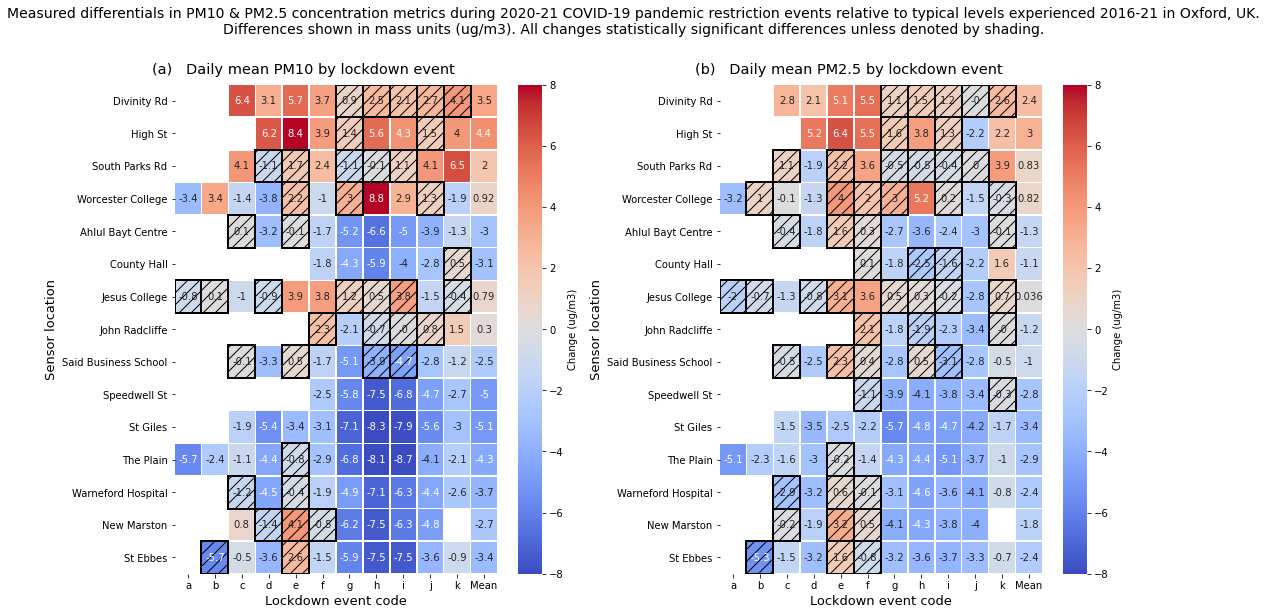

In [12]:
# Heat map - pm10 & pm2.5 daily mean
#------------------------------------
sort_map = {'County Hall':5,
            'Divinity Rd':0,
            'High St':1,
            'Ahlul Bayt Centre':4,
            'Jesus College':6,
            'John Radcliffe':7,
            'New Marston':13,
            'Said Business School':8,
            'South Parks Rd':2,
            'Speedwell St':9,
            'St Ebbes':14,
            'St Giles':10,
            'The Plain':11,
            'Warneford Hospital':12,
            'Worcester College':3,
            'Mean':15
           }

dif_pm10_mean['order'] = dif_pm10_mean.index.map(sort_map)
dif_pm10_mean1 = dif_pm10_mean[:-1]
dif_pm10_mean1['order'] = dif_pm10_mean1['order'].astype('int32')
dif_pm10_mean1.sort_values(by='order',inplace=True)
dif_pm10_mean1 = dif_pm10_mean1.drop(columns=['order'])

dif_pm25_mean['order'] = dif_pm25_mean.index.map(sort_map)
dif_pm25_mean1 = dif_pm25_mean[:-1]
dif_pm25_mean1['order'] = dif_pm25_mean1['order'].astype('int32')
dif_pm25_mean1.sort_values(by='order',inplace=True)
dif_pm25_mean1 = dif_pm25_mean1.drop(columns=['order'])

pm10_mean_wilcoxon['order'] = pm10_mean_wilcoxon['fname'].map(sort_map)
pm10_mean_wilcoxon['order'] = pm10_mean_wilcoxon['order'].astype('int32')
pm10_mean_wilcoxon.sort_values(by='order',inplace=True)

pm25_mean_wilcoxon['order'] = pm25_mean_wilcoxon['fname'].map(sort_map)
pm25_mean_wilcoxon['order'] = pm25_mean_wilcoxon['order'].astype('int32')
pm25_mean_wilcoxon.sort_values(by='order',inplace=True)


fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(17,9))

sns.heatmap(dif_pm10_mean1, annot=True, cmap='coolwarm', robust=True, ax=ax1, linewidths=.5, vmin=-8, vmax=8, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm10_mean_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax1.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


# pm2.5
#-------
sns.heatmap(dif_pm25_mean1, annot=True, cmap='coolwarm', robust=True, ax=ax2, linewidths=.5, vmin=-8, vmax=8, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm25_mean_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax2.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


    
ax1.set_title('(a)   Daily mean PM10 by lockdown event', y=1.01, x=0.4, fontsize=14.5)    
ax2.set_title('(b)   Daily mean PM2.5 by lockdown event', y=1.01, x=0.4, fontsize=14.5)
ax1.set_xlabel('Lockdown event code', fontsize=13)
ax1.set_ylabel('Sensor location', fontsize=13)
ax2.set_xlabel('Lockdown event code', fontsize=13)
ax2.set_ylabel('Sensor location', fontsize=13)

fig.suptitle('Measured differentials in PM10 & PM2.5 concentration metrics during 2020-21 COVID-19 pandemic restriction events relative to typical levels experienced 2016-21 in Oxford, UK.\nDifferences shown in mass units (ug/m3). All changes statistically significant differences unless denoted by shading.', fontsize=14, y=1)

#plt.tight_layout() 
plt.subplots_adjust(wspace=0.35, hspace=0.2)

plt.savefig('sensor_vs_typical_year_heatmap_24hrmean_1619.png')

plt.show()

    

In [13]:
dif_pm10_mean

Event code,a,b,c,d,e,f,g,h,i,j,k,Mean,order
Sensor,,,,,,,,,,,,,
Ahlul Bayt Centre,NaN,NaN,0.100000,-3.200000,-0.100000,-1.700000,-5.2,-6.600000,-5.000000,-3.900000,-1.300000,-2.988889,4
County Hall,NaN,NaN,NaN,NaN,NaN,-1.800000,-4.3,-5.900000,-4.000000,-2.800000,0.500000,-3.050000,5
Divinity Rd,NaN,NaN,6.400000,3.100000,5.700000,3.700000,0.9,2.500000,2.100000,2.700000,4.100000,3.466667,0
High St,NaN,NaN,NaN,6.200000,8.400000,3.900000,1.4,5.600000,4.300000,1.500000,4.000000,4.412500,1
Jesus College,-0.8,0.10,-1.000000,-0.900000,3.900000,3.800000,1.2,0.500000,3.800000,-1.500000,-0.400000,0.790909,6
John Radcliffe,NaN,NaN,NaN,NaN,NaN,2.300000,-2.1,-0.700000,-0.000000,0.800000,1.500000,0.300000,7
New Marston,NaN,NaN,0.800000,-1.400000,4.100000,-0.500000,-6.2,-7.500000,-6.300000,-4.800000,NaN,-2.725000,13
Said Business School,NaN,NaN,-0.100000,-3.300000,0.500000,-1.700000,-5.1,-3.900000,-4.700000,-2.800000,-1.200000,-2.477778,8
South Parks Rd,NaN,NaN,4.100000,-1.100000,1.700000,2.400000,-1.1,-0.100000,1.100000,4.100000,6.500000,1.955556,2


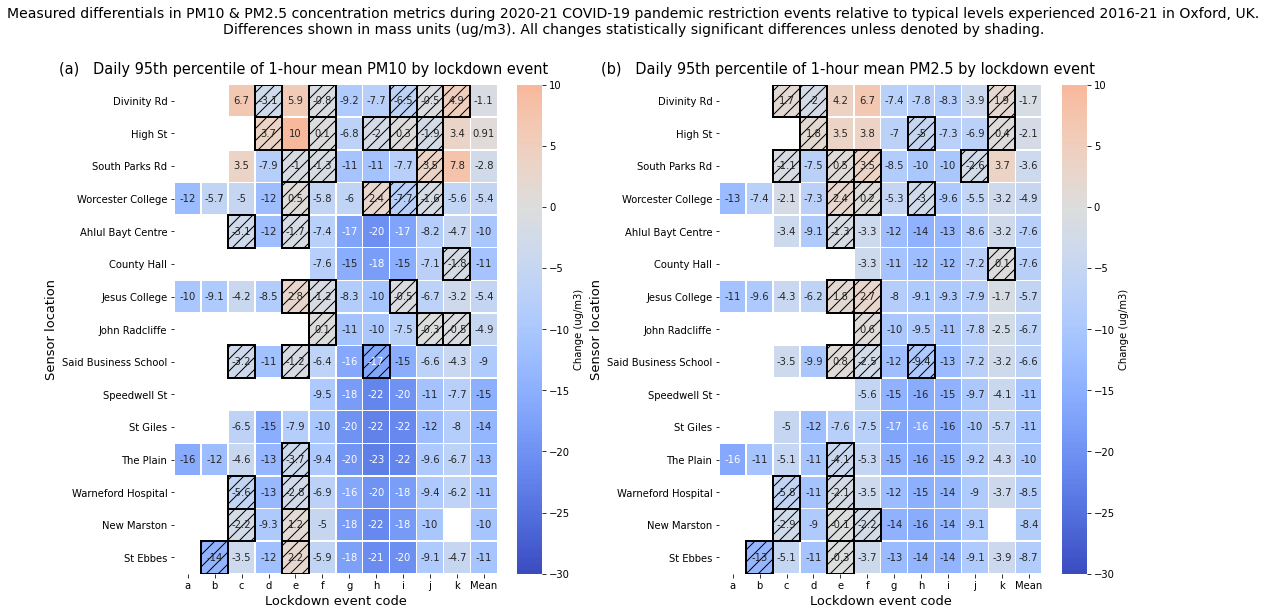

In [13]:
# Heat map - pm10 & pm2.5 daily p95 of 1-hour means
#---------------------------------------------------
sort_map = {'County Hall':5,
            'Divinity Rd':0,
            'High St':1,
            'Ahlul Bayt Centre':4,
            'Jesus College':6,
            'John Radcliffe':7,
            'New Marston':13,
            'Said Business School':8,
            'South Parks Rd':2,
            'Speedwell St':9,
            'St Ebbes':14,
            'St Giles':10,
            'The Plain':11,
            'Warneford Hospital':12,
            'Worcester College':3
           }

dif_pm10_p95['order'] = dif_pm10_p95.index.map(sort_map)
dif_pm10_p951 = dif_pm10_p95[:-1]
dif_pm10_p951['order'] = dif_pm10_p951['order'].astype('int32')
dif_pm10_p951.sort_values(by='order',inplace=True)
dif_pm10_p951 = dif_pm10_p951.drop(columns=['order'])

dif_pm25_p95['order'] = dif_pm25_p95.index.map(sort_map)
dif_pm25_p951 = dif_pm25_p95[:-1]
dif_pm25_p951['order'] = dif_pm25_p951['order'].astype('int32')
dif_pm25_p951.sort_values(by='order',inplace=True)
dif_pm25_p951 = dif_pm25_p951.drop(columns=['order'])

pm10_p95_wilcoxon['order'] = pm10_p95_wilcoxon['fname'].map(sort_map)
pm10_p95_wilcoxon['order'] = pm10_p95_wilcoxon['order'].astype('int32')
pm10_p95_wilcoxon.sort_values(by='order',inplace=True)

pm25_p95_wilcoxon['order'] = pm25_p95_wilcoxon['fname'].map(sort_map)
pm25_p95_wilcoxon['order'] = pm25_p95_wilcoxon['order'].astype('int32')
pm25_p95_wilcoxon.sort_values(by='order',inplace=True)


fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(17,9))

sns.heatmap(dif_pm10_p951, annot=True, cmap='coolwarm', robust=True, ax=ax1, linewidths=.5, center=0, vmin=-30, vmax=10, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm10_p95_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax1.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


# pm2.5
#-------
sns.heatmap(dif_pm25_p951, annot=True, cmap='coolwarm', robust=True, ax=ax2, linewidths=.5, center=0, vmin=-30, vmax=10, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm25_p95_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax2.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


    
ax1.set_title('(a)   Daily 95th percentile of 1-hour mean PM10 by lockdown event', y=1.01, x=0.4, fontsize=14.5)    
ax2.set_title('(b)   Daily 95th percentile of 1-hour mean PM2.5 by lockdown event', y=1.01, x=0.4, fontsize=14.5)
ax1.set_xlabel('Lockdown event code', fontsize=13)
ax1.set_ylabel('Sensor location', fontsize=13)
ax2.set_xlabel('Lockdown event code', fontsize=13)
ax2.set_ylabel('Sensor location', fontsize=13)

fig.suptitle('Measured differentials in PM10 & PM2.5 concentration metrics during 2020-21 COVID-19 pandemic restriction events relative to typical levels experienced 2016-21 in Oxford, UK.\nDifferences shown in mass units (ug/m3). All changes statistically significant differences unless denoted by shading.', fontsize=14, y=1)

#plt.tight_layout() 
plt.subplots_adjust(wspace=0.35, hspace=0.2)

plt.savefig('sensor_vs_typical_year_heatmap_p95_1619.png')

plt.show()


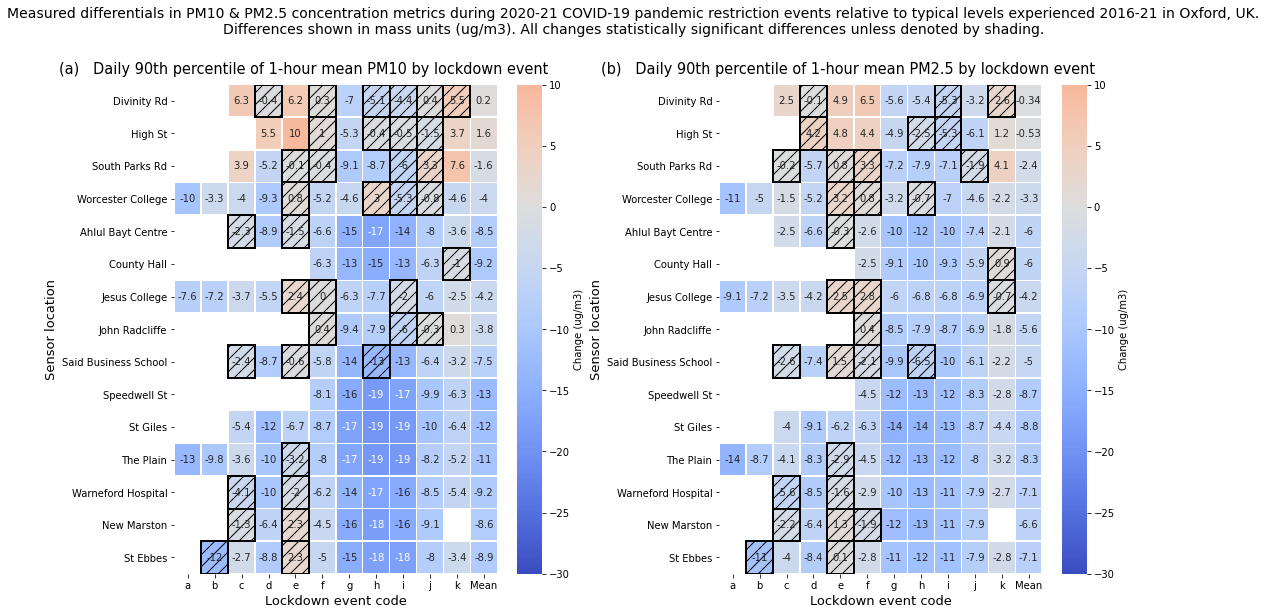

In [15]:
# Heat map - pm10 & pm2.5 daily p90 of 1-hour means
#---------------------------------------------------
sort_map = {'County Hall':5,
            'Divinity Rd':0,
            'High St':1,
            'Ahlul Bayt Centre':4,
            'Jesus College':6,
            'John Radcliffe':7,
            'New Marston':13,
            'Said Business School':8,
            'South Parks Rd':2,
            'Speedwell St':9,
            'St Ebbes':14,
            'St Giles':10,
            'The Plain':11,
            'Warneford Hospital':12,
            'Worcester College':3
           }

dif_pm10_p90['order'] = dif_pm10_p90.index.map(sort_map)
dif_pm10_p901 = dif_pm10_p90[:-1]
dif_pm10_p901['order'] = dif_pm10_p901['order'].astype('int32')
dif_pm10_p901.sort_values(by='order',inplace=True)
dif_pm10_p901 = dif_pm10_p901.drop(columns=['order'])

dif_pm25_p90['order'] = dif_pm25_p90.index.map(sort_map)
dif_pm25_p901 = dif_pm25_p90[:-1]
dif_pm25_p901['order'] = dif_pm25_p901['order'].astype('int32')
dif_pm25_p901.sort_values(by='order',inplace=True)
dif_pm25_p901 = dif_pm25_p901.drop(columns=['order'])

pm10_p90_wilcoxon['order'] = pm10_p90_wilcoxon['fname'].map(sort_map)
pm10_p90_wilcoxon['order'] = pm10_p90_wilcoxon['order'].astype('int32')
pm10_p90_wilcoxon.sort_values(by='order',inplace=True)

pm25_p90_wilcoxon['order'] = pm25_p90_wilcoxon['fname'].map(sort_map)
pm25_p90_wilcoxon['order'] = pm25_p90_wilcoxon['order'].astype('int32')
pm25_p90_wilcoxon.sort_values(by='order',inplace=True)


fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(17,9))

sns.heatmap(dif_pm10_p901, annot=True, cmap='coolwarm', robust=True, ax=ax1, linewidths=.5, center=0, vmin=-30, vmax=10, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm10_p90_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax1.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


# pm2.5
#-------
sns.heatmap(dif_pm25_p901, annot=True, cmap='coolwarm', robust=True, ax=ax2, linewidths=.5, center=0, vmin=-30, vmax=10, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm25_p90_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax2.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


    
ax1.set_title('(a)   Daily 90th percentile of 1-hour mean PM10 by lockdown event', y=1.01, x=0.4, fontsize=14.5)    
ax2.set_title('(b)   Daily 90th percentile of 1-hour mean PM2.5 by lockdown event', y=1.01, x=0.4, fontsize=14.5)
ax1.set_xlabel('Lockdown event code', fontsize=13)
ax1.set_ylabel('Sensor location', fontsize=13)
ax2.set_xlabel('Lockdown event code', fontsize=13)
ax2.set_ylabel('Sensor location', fontsize=13)

fig.suptitle('Measured differentials in PM10 & PM2.5 concentration metrics during 2020-21 COVID-19 pandemic restriction events relative to typical levels experienced 2016-21 in Oxford, UK.\nDifferences shown in mass units (ug/m3). All changes statistically significant differences unless denoted by shading.', fontsize=14, y=1)

#plt.tight_layout() 
plt.subplots_adjust(wspace=0.35, hspace=0.2)

plt.savefig('sensor_vs_typical_year_heatmap_p90_1619.png')

plt.show()


In [ ]:
# Heat map - pm10 & pm2.5 daily mean ratios
#-------------------------------------------
sort_map = {'County Hall':5,
            'Divinity Rd':0,
            'High St':1,
            'Ahlul Bayt Centre':4,
            'Jesus College':6,
            'John Radcliffe':7,
            'New Marston':13,
            'Said Business School':8,
            'South Parks Rd':2,
            'Speedwell St':9,
            'St Ebbes':14,
            'St Giles':10,
            'The Plain':11,
            'Warneford Hospital':12,
            'Worcester College':3,
            'Mean':15
           }

dif_pm10_mean['order'] = dif_pm10_mean.index.map(sort_map)
dif_pm10_mean1 = dif_pm10_mean[:-1]
dif_pm10_mean1['order'] = dif_pm10_mean1['order'].astype('int32')
dif_pm10_mean1.sort_values(by='order',inplace=True)
dif_pm10_mean1 = dif_pm10_mean1.drop(columns=['order'])

dif_pm25_mean['order'] = dif_pm25_mean.index.map(sort_map)
dif_pm25_mean1 = dif_pm25_mean[:-1]
dif_pm25_mean1['order'] = dif_pm25_mean1['order'].astype('int32')
dif_pm25_mean1.sort_values(by='order',inplace=True)
dif_pm25_mean1 = dif_pm25_mean1.drop(columns=['order'])

pm10_mean_wilcoxon['order'] = pm10_mean_wilcoxon['fname'].map(sort_map)
pm10_mean_wilcoxon['order'] = pm10_mean_wilcoxon['order'].astype('int32')
pm10_mean_wilcoxon.sort_values(by='order',inplace=True)

pm25_mean_wilcoxon['order'] = pm25_mean_wilcoxon['fname'].map(sort_map)
pm25_mean_wilcoxon['order'] = pm25_mean_wilcoxon['order'].astype('int32')
pm25_mean_wilcoxon.sort_values(by='order',inplace=True)


fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(17,9))

sns.heatmap(dif_pm10_mean1, annot=True, cmap='coolwarm', robust=True, ax=ax1, linewidths=.5, vmin=-8, vmax=8, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm10_mean_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax1.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


# pm2.5
#-------
sns.heatmap(dif_pm25_mean1, annot=True, cmap='coolwarm', robust=True, ax=ax2, linewidths=.5, vmin=-8, vmax=8, cbar_kws={'label': 'Change (ug/m3)'})
tmpdf = pm25_mean_wilcoxon[['order','ld_code', 'P'
                          ]].pivot(index='order',columns='ld_code').droplevel([0], axis=1
                                            ).reset_index(drop=True
                                                         ).T.reset_index(drop=True
                                                                        ).T.stack()
tmpdf = tmpdf[tmpdf > 0.05]
t = tmpdf.index.values.tolist()
for i in t:
    ax2.add_patch(Rectangle((i[1], i[0]), 1, 1, fill=False, edgecolor='black', lw=2, hatch='//'))


    
ax1.set_title('(a)   Daily mean PM10 by lockdown event', y=1.01, x=0.4, fontsize=14.5)    
ax2.set_title('(b)   Daily mean PM2.5 by lockdown event', y=1.01, x=0.4, fontsize=14.5)
ax1.set_xlabel('Lockdown event code', fontsize=13)
ax1.set_ylabel('Sensor location', fontsize=13)
ax2.set_xlabel('Lockdown event code', fontsize=13)
ax2.set_ylabel('Sensor location', fontsize=13)

fig.suptitle('Measured differentials in PM10 & PM2.5 concentration metrics during 2020-21 COVID-19 pandemic restriction events relative to typical levels experienced 2016-21 in Oxford, UK.\nDifferences shown in mass units (ug/m3). All changes statistically significant differences unless denoted by shading.', fontsize=14, y=1)

#plt.tight_layout() 
plt.subplots_adjust(wspace=0.35, hspace=0.2)

plt.savefig('sensor_vs_typical_year_heatmap_24hrmean_1619.png')

plt.show()

    